In [1]:
import sys
import os
import importlib
import shutil
import numpy as np
import threading
# import keras
import tqdm
import _init_paths
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import selectivesearch
importlib.reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import PIL
import tqdm
import lib.utils.general as general; importlib.reload(general)
from lib.utils.general import *

import pascal_voc_reader

import bbox_transform
importlib.reload(bbox_transform)
from bbox_transform import *

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F

# import dataset; importlib.reload(dataset); from dataset import *
import dataset_roidb; importlib.reload(dataset_roidb)
from dataset_roidb import Pascal_roidb

import rcnn_utils
importlib.reload(rcnn_utils)
from rcnn_utils import *

import data_utils
importlib.reload(data_utils)
from data_utils import *

from IPython.core.debugger import Tracer
from IPython.display import clear_output

%matplotlib inline

from roi_pooling.modules.roi_pool import RoIPool as RoIPool_GPU

from utils.config import cfg

## Playing with RoI Polling

In [4]:
batch = train_set[1]

In [5]:
sample = train_set.samples[1]
sample

{'bbox_targets': array([[  7.0000e+00,   0.0000e+00,  -5.3172e-03,   3.1685e-03,  -3.4773e-01],
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00],
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00],
        ..., 
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00],
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00],
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00]], dtype=float32),
 'boxes': array([[140,  49, 499, 329],
        [  0,   0,  40,  37],
        [  0,   0,  86,  37],
        ..., 
        [227, 322, 246, 332],
        [ 61, 323,  81, 332],
        [356, 325, 375, 332]], dtype=uint16),
 'flipped': False,
 'gt_classes': array([7, 0, 0, ..., 0, 0, 0], dtype=int32),
 'gt_overlaps': <2745x21 sparse matrix of type '<class 'numpy.float32'>'
 	with 2175 stored elements in Compressed Sparse Row format>,
 'height': 333,
 'image': '../VOC/VOCdev

In [6]:
batch[1].size()

torch.Size([3, 600, 923])

In [7]:
rois = Variable(torch.Tensor([[0, 0, 0, 800, 600]]))

In [8]:
img = batch[1]

In [9]:
img_var = Variable(img.view((1,) + img.size()), volatile=True)

In [10]:
vgg = get_vgg_conv(1)

In [22]:
vgg

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

In [12]:
img = PIL.Image.open(sample['image'])

In [13]:
img.size

(500, 333)

In [14]:
img_arr = np.asarray(img).astype(float).transpose((2, 0, 1))

In [15]:
img_arr.shape

(3, 333, 500)

In [16]:
img = torch.Tensor(img_arr)

In [17]:
img.view((1,) + img.size())


( 0 , 0 ,.,.) = 
   70   40   19  ...    78   46   33
  196  213    4  ...    71  102   59
   16   71   34  ...    41    9   56
      ...         ⋱        ...      
   78   46   77  ...    12   15   16
   72  134   73  ...    19   26   21
   79  100   42  ...    16   22   19

( 0 , 1 ,.,.) = 
   29   17   21  ...   117   76   58
  188  214   12  ...    91  122   83
   49   96   51  ...    52   29   84
      ...         ⋱        ...      
  103   67   97  ...    14   17   18
   88  151   92  ...    21   28   23
   86  113   60  ...    18   24   21

( 0 , 2 ,.,.) = 
   23    9    8  ...    88   48   26
  177  200    0  ...    64   94   49
   30   77   33  ...    22    0   43
      ...         ⋱        ...      
   38   10   46  ...    13   16   17
   25   97   47  ...    20   27   22
   32   67   22  ...    17   23   20
[torch.FloatTensor of size 1x3x333x500]

In [18]:
img_var = Variable(img.view((1,) + img.size()), volatile=True)

In [19]:
features = vgg(img_var)

In [20]:
features[0, 0]

Variable containing:

Columns 0 to 7 
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
  

In [21]:
roi_pooling = RoIPool_GPU(7, 7,
                        spatial_scale=1. / 16)


In [22]:
np.get_printoptions()

{'edgeitems': 3,
 'formatter': None,
 'infstr': 'inf',
 'linewidth': 100,
 'nanstr': 'nan',
 'precision': 4,
 'suppress': False,
 'threshold': 1000}

In [43]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=180)


In [44]:
features[0][0].data.numpy().astype(int)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0

In [46]:
features[0][0].data.numpy().shape

(20, 31)

In [49]:
np.array([ 20, 31 ]) * 16

array([320, 496])

In [61]:
rois = Variable(torch.Tensor(np.array([[0., 0., 0., 320., 496.]])))

In [62]:
roi_pooling.forward(features, rois)[0][0]

Variable containing:
   3.2646  104.9033   20.1432    0.0000   69.3347   29.1211   56.3171
   0.0000  104.9033   91.3464   79.4286   98.9582    0.0000    0.0000
  38.0952   26.8189   91.3464    0.0000   34.1073   13.8398    0.0000
  38.0952    0.0000   60.9711  150.7188  107.3427    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
[torch.FloatTensor of size 7x7]

In [63]:
roi_pool_cpu = RoIPool_CPU(7, 7, 1./16)

In [64]:
# if True:
#     Tracer()()
roi_pool_cpu.forward(features, rois)[0][0]

Variable containing:
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000   48.9708    9.7008    0.0000    0.0000
   1.8766    0.0000    0.0000    0.0000    0.0000    0.0000  146.4150
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
[torch.cuda.FloatTensor of size 7x7 (GPU 0)]

In [65]:
F.adaptive_max_pool2d(features, (7, 7))[0][0]

Variable containing:
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000   48.9708    0.0000    0.0000    0.0000    0.0000
   0.0000    0.0000   48.9708    0.0000   41.4423   41.4423    0.0000
   1.8766    0.0000    0.0000    0.0000  146.4150   54.4697    7.5315
[torch.FloatTensor of size 7x7]

In [37]:
features.size()

torch.Size([1, 512, 20, 31])

In [30]:
from roi_pooling.modules.roi_pool_py import RoIPool as RoIPool_CPU


## Load Data

In [3]:
try:
    del train_set
    del train_loader
except:
    pass
cfg.DATA_DIR = '../VOC/'
devkit_path = os.path.join(cfg.DATA_DIR, 'VOCdevkit/')
train_set = Pascal_roidb(devkit_path, 'trainval', '2007', 
                        shuffle_samples=True)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=False, num_workers=2)


Loaded from cache.


#### the other data loader

In [3]:
try:
    del train_set
    del train_loader
except:
    pass
train_set = Pascal_VOC(data_path='../VOC/VOCdevkit/', 
                           year='2007', set_name='trainval')

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=False, num_workers=2)


## Fast RCNN after conv layers

In [4]:
try:
    del fast_rcnn_model
except NameError:
    pass

fast_rcnn_model = Fast_RCNN_model(dropout_p=0.5).cuda()
fast_rcnn_weights_init(fast_rcnn_model)

In [5]:
# test
batch = next(train_loader.__iter__())
index, _, rois, targets, labels, preds_weights = [item[0] for item in batch]
image = batch[1]

image_var = Variable(image.cuda())
rois_var = Variable(rois.float().cuda())
out = fast_rcnn_model.forward(image_var, rois_var)
out[0].size(), out[1].size()

(torch.Size([64, 21]), torch.Size([64, 84]))

## Train loop

In [6]:
def train(net, dataset, loss_criterion, optimizer, 
          iterations=30000, print_every=10):
    net.train()
    total_loss = 0
    data_iterator = dataset.__iter__()
    t = tqdm.tqdm_notebook(total=iterations)
    current_iteration = 1
    while True:
        try:
            batch = next(data_iterator)
        except StopIteration:
            data_iterator = dataset.__iter__()
            batch = next(data_iterator)

        (_, _, rois, targets, labels,
         preds_weights) = [item[0] for item in batch]
        image = batch[1]

        images_var = Variable(image.cuda())
        rois_var = Variable(rois.float().cuda())

        targets_var = Variable(targets.cuda())
        labels_var = Variable(labels.cuda())
        preds_weights_var = Variable(preds_weights.cuda())
        
        # Clear Gradients
        optimizer.zero_grad()

        # Forward Pass
        output = net(images_var, rois_var)

        loss = loss_criterion(output, labels_var, targets_var, 
                             preds_weights_var)

        # Backprop
        loss.backward()
        optimizer.step()

        total_loss += loss.data[0]
        current_mean_loss = total_loss / current_iteration
        if (current_iteration + 1) % print_every == 0:
            clear_output()
            print(current_mean_loss, end=' ')

        current_iteration += 1
        if current_iteration > iterations:
            break
        t.update()
    t.close()
    mean_loss = total_loss / iterations
    return mean_loss


## Run the training

In [7]:
saved_path = 'intermediate/voc/weights-sgd-improved-130k.pth'
load_weights(fast_rcnn_model, saved_path)

In [8]:
def get_parameters(net, lr):
    ''' Get the parameters that have gradients flowing through them, 
        with different lr for biases and weights.
    '''
    biases = []
    weights = []
    for name, param in net.named_parameters():
        if param.requires_grad:
            if 'bias' in name:
                biases.append(param)
            else:
                weights.append(param)
    return [{'params': biases, 'lr': lr * 2},
            {'params': weights, 'lr': lr},
           ]
    

In [7]:
learning_rate = 1e-3
params = get_parameters(fast_rcnn_model, learning_rate)

In [8]:
# optimizer = torch.optim.Adam(params, lr=learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, loss_criterion, 
      optimizer, iterations=30000)

0.20576343358318905 


0.20575989853314436

In [9]:
learning_rate = 1e-4
params = get_parameters(fast_rcnn_model, learning_rate)
# optimizer = torch.optim.Adam(params, lr=learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, loss_criterion, 
      optimizer, iterations=40000)

0.11396680146643413 


0.11396886551583447

In [10]:
learning_rate = 1e-5
params = get_parameters(fast_rcnn_model, learning_rate)
# optimizer = torch.optim.Adam(params, lr=learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, loss_criterion, 
      optimizer, iterations=40000)

0.10168317765662374 


0.10168451584551767

In [11]:
saved_path = save_weights(fast_rcnn_model, 'intermediate/voc', 
                          'sgd-improved-210k')
saved_path

'intermediate/voc/weights-sgd-improved-210k.pth'

## Test the net

In [5]:
iterator = train_loader.__iter__()

In [10]:
batch = next(iterator)
index, images, rois, targets = batch
index = index.cpu().numpy()[0]
images_var = Variable(images.cuda())
rois_var = Variable(rois[0].float().cuda())

out = fast_rcnn_model(images_var, rois_var)

In [11]:
out[0]

Variable containing:
-1.6140e-01 -5.2249e+00 -1.0904e+01  ...  -1.2932e+01 -5.5041e+00 -1.9640e+01
-1.3144e-01 -4.4448e+00 -6.7060e+00  ...  -1.4186e+01 -4.6301e+00 -1.8751e+01
-8.8956e-01 -6.0059e+00 -9.2580e+00  ...  -3.1519e+01 -7.6960e+00 -3.9739e+01
                ...                   ⋱                   ...                
-2.0999e-02 -5.3142e+00 -9.1639e+00  ...  -1.6007e+01 -6.9217e+00 -1.4208e+01
-1.2471e-01 -4.3938e+00 -6.6681e+00  ...  -8.4041e+00 -3.7703e+00 -1.0631e+01
-3.6229e-01 -3.2923e+00 -4.5783e+00  ...  -4.2587e+00 -4.6405e+00 -4.4792e+00
[torch.cuda.FloatTensor of size 128x21 (GPU 0)]

tvmonitor
aeroplane
tvmonitor
boat
boat
boat
boat
boat
boat


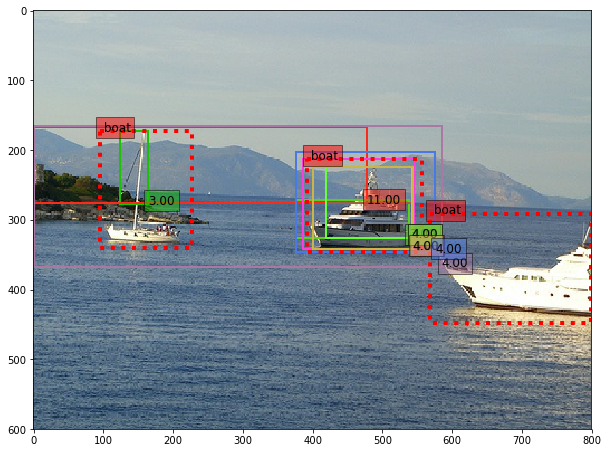

In [21]:
probas, indexes = torch.max(out[0], 1)
indexes_np = np.squeeze(indexes.data.cpu().numpy())
non_bg_rois_indexes = (indexes_np > 0)
'Total Detected: ', np.sum(non_bg_rois_indexes)

non_bg_rois = rois_var.data.cpu().numpy()[non_bg_rois_indexes]

detected_roi = np.append(non_bg_rois[:, 1:],
                         indexes_np[non_bg_rois_indexes][:, None],
                         axis=1)

detected_roi.shape

image = train_set._get_image(train_set.samples[index])
# image = PIL.Image.fromarray(image_arr.astype('uint8'))

for class_id in detected_roi[:, 4]:
    print(train_set.class_id_to_name[class_id])

gt_boxes = train_set.samples[index]['gt_boxes_xywh']
    
display_image_regions(image, 
                      x1y1x2y2_to_xywh(detected_roi), 
                      gt_boxes, 
                      class_id_to_name=train_set.class_id_to_name)

In [19]:
train_set.samples[index][]

{'bbox_targets': array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]], dtype=float32),
 'bboxes': [{'class': 'boat', 'x1': 356, 'x2': 500, 'y1': 183, 'y2': 280},
  {'class': 'boat', 'x1': 60, 'x2': 142, 'y1': 109, 'y2': 213},
  {'class': 'boat', 'x1': 246, 'x2': 348, 'y1': 134, 'y2': 217}],
 'filename': '000241.jpg',
 'filepath': '../VOC/VOCdevkit/VOC2007/JPEGImages/000241.jpg',
 'gt_boxes_xywh': array([[ 568. ,  291.2,  231.4,  156.2,    4. ],
        [  94.4,  172.8,  132.2,  167.4,    4. ],
        [ 392. ,  212.8,  164.2,  133.8,    4. ]]),
 'gt_boxes_xyxy': array([[ 568. ,  291.2,  798.4,  446.4,    4. ],
        [  94.4,  172.8,  225.6,  339.2,    4. ],
        [ 392. ,  212.8,  555.2,  345.6,    4. ]]),
 'gt_overlaps': <1014x21 sparse matrix of type '<class 'numpy.float32'>'
 	with 648 stored elements in Compres

In [17]:
detected_roi

array([[ 123.2,  172.8,  163.2,  276.8,    3. ],
       [   0. ,  166.4,  476.8,  275.2,   11. ],
       [ 376. ,  272. ,  537.6,  324.8,    3. ],
       [ 419.2,  275.2,  540.8,  324.8,    4. ],
       [   0. ,  164.8,  584. ,  366.4,    4. ],
       [ 385.6,  212.8,  544. ,  340.8,    4. ],
       [ 419.2,  224. ,  540.8,  324.8,    4. ],
       [ 400. ,  224. ,  542.4,  340.8,    4. ],
       [ 376. ,  203.2,  574.4,  345.6,    4. ]])

In [13]:
sample = train.samples[index.numpy()[0]]

In [14]:
img = train._get_image(sample)

In [15]:
gts = sample['gt_boxes_xyxy']

In [16]:
gts[:4]

array([[ 568. ,  291.2,  798.4,  446.4,    4. ],
       [  94.4,  172.8,  225.6,  339.2,    4. ],
       [ 392. ,  212.8,  555.2,  345.6,    4. ]])

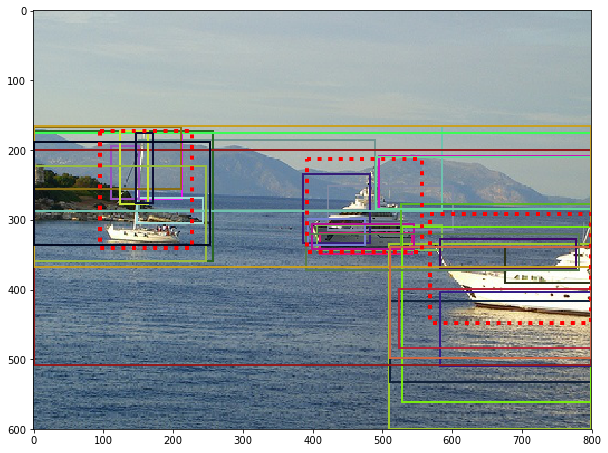

In [22]:
display_image_regions(np.asarray(img), 
                      x1y1x2y2_to_xywh(rois[0].cpu().numpy()[32:64, 1:]), 
                      x1y1x2y2_to_xywh(gts[:, :4]))